#Imports

In [1]:
import tensorflow as tf
from tensorflow import keras
import ipywidgets

In [2]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()
print(tf.version.VERSION)
import sys
sys.version

Num GPUs Available:  1
2.12.0


'3.10.11 (main, Apr  5 2023, 14:15:10) [GCC 9.4.0]'

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [4]:
import os
import io
import matplotlib.pyplot as plt
import cv2
import imageio
#import medmnist
#import ipywidgets
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import ModelCheckpoint
import cv2 as cv
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense
from keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras import layers, models
# Setting seed for reproducibility
SEED = 42
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"
np.random.seed(SEED)

#Hyper parameters

In [5]:
# DATA
DATASET_NAME = "LAD2000"
BATCH_SIZE = 64
PATH = '/content/gdrive/MyDrive/All extracted frames/mama data/lad/'
Extraction_Name = ''
# AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = (75, 75, 15, 3)
NUM_CLASSES = 9

# OPTIMIZER
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-5

# TRAINING
EPOCHS = 50

# TUBELET EMBEDDING
PATCH_SIZE = (8, 8, 8)
NUM_PATCHES = (INPUT_SHAPE[0] // PATCH_SIZE[0]) ** 2

# ViViT ARCHITECTURE
LAYER_NORM_EPS = 1e-6
PROJECTION_DIM = 128
NUM_HEADS = 8
NUM_LAYERS = 8

#Loading data

In [ ]:
X_train, y_train = np.load(PATH + 'X_train.npy', mmap_mode = 'r'), np.load(PATH + 'y_train.npy')
X_val, y_val = np.load(PATH + 'X_val.npy', mmap_mode = 'r'), np.load(PATH + 'y_val.npy')
X_test, y_test = np.load(PATH + 'X_test.npy', mmap_mode = 'r'), np.load(PATH + 'y_test.npy')

In [6]:
X_test, y_test = np.load(PATH + 'X_test.npy', mmap_mode = 'r'), np.load(PATH + 'y_test.npy')

In [7]:
def stringtoint(y):
    for i, val in enumerate(y):
        if val == 'Crash':
            y[i] = 0
        elif val == 'Destroy':
            y[i] = 1
        elif val == 'Drop':
            y[i] = 2
        elif val == 'Fighting':
            y[i] = 3
        elif val == 'Fire':
            y[i] = 4
        elif val == 'Hurt':
            y[i] = 5
        elif val == 'Thiefing':
            y[i] = 6
        elif val == 'Trampled':
            y[i] = 7
        elif val == 'Violence':
            y[i] = 8                          
    return y

In [ ]:
y_train = stringtoint(y_train)
y_val = stringtoint(y_val)


In [8]:
y_test = stringtoint(y_test)

In [9]:
#print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
#print(X_val.shape, y_val.shape)

(4407, 15, 75, 75, 3) (4407,)


In [10]:
#X_train = np.moveaxis(X_train, 1, 3)
#X_val = np.moveaxis(X_val, 1, 3)
X_test = np.moveaxis(X_test, 1, 3)

In [11]:
#y_train = to_categorical(y_train, 9)
#y_val = to_categorical(y_val, 9)
y_test = to_categorical(y_test, 9)

In [ ]:
y_train[50]


array([0., 0., 0., 1., 0., 0., 0., 0., 0.], dtype=float32)

#Data Generator

In [14]:
class DataGenerator(keras.utils.Sequence):

    def __init__(self, x_in, y_in, batch_size=BATCH_SIZE, shuffle=True):
        # Initialization
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.x = x_in
        self.y = y_in
        self.datalen = len(y_in)
        self.indexes = np.arange(self.datalen)
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        # get batch indexes from shuffled indexes
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        x_batch = self.x[batch_indexes]
        y_batch = self.y[batch_indexes]
        return x_batch, y_batch
    
    def __len__(self):
        # Denotes the number of batches per epoch
        return self.datalen // self.batch_size

    def on_epoch_end(self):
        # Updates indexes after each epoch
        self.indexes = np.arange(self.datalen)
        if self.shuffle:
            np.random.shuffle(self.indexes)

#training_generator = DataGenerator(X_train, y_train)
#validation_generator = DataGenerator(X_val, y_val)

#ViVit Model

In [12]:
class TubeletEmbedding(layers.Layer):
    def __init__(self, embed_dim, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.projection = layers.Conv3D(
            filters=embed_dim,
            kernel_size=patch_size,
            strides=patch_size,
            padding="VALID",
        )
        self.flatten = layers.Reshape(target_shape=(-1, embed_dim))

    def call(self, videos):
        projected_patches = self.projection(videos)
        flattened_patches = self.flatten(projected_patches)
        return flattened_patches

In [13]:
class PositionalEncoder(layers.Layer):
    def __init__(self, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim

    def build(self, input_shape):
        _, num_tokens, _ = input_shape
        self.position_embedding = layers.Embedding(
            input_dim=num_tokens, output_dim=self.embed_dim
        )
        self.positions = tf.range(start=0, limit=num_tokens, delta=1)

    def call(self, encoded_tokens):
        # Encode the positions and add it to the encoded tokens
        encoded_positions = self.position_embedding(self.positions)
        encoded_tokens = encoded_tokens + encoded_positions
        return encoded_tokens

##Checkpoints and callbacks

In [14]:
checkpoint_filepath = '/content/gdrive/MyDrive/Checkpoints/lad_mama_version_vivit/checkpoint/'
model_checkpoint = model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                filepath=checkpoint_filepath,
                                save_weights_only=True,
                                monitor='val_loss',
                                mode='min',
                                save_best_only=True
                                )

In [15]:
from keras.callbacks import ReduceLROnPlateau
checkpoint_filepath = '/content/gdrive/MyDrive/Checkpoints/lad_mama_version_vivit/checkpoint/'
checkpoint = model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                filepath=checkpoint_filepath,
                                save_weights_only=True,
                                monitor='val_loss',
                                mode='min',
                                save_best_only=True
                                )

earlystopping = tf.keras.callbacks.EarlyStopping(
                     monitor="val_loss",
                     min_delta=0.025,
                     patience=5,
                     verbose=0,
                     mode="min",
                     baseline=None,
                     restore_best_weights=False
                 )

values = np.linspace(0.00001,LEARNING_RATE,14)[::-1].astype(np.float32)
boundaries = np.linspace(5, 45,13)[:values.shape[0]-1].astype(np.int32)

scheduler = keras.optimizers.schedules.PiecewiseConstantDecay(
    list(boundaries), list(values))

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.000001)

callbacks = [checkpoint, lr_scheduler, reduce_lr]

In [16]:
def create_vivit_classifier(
    tubelet_embedder,
    positional_encoder,
    input_shape=INPUT_SHAPE,
    transformer_layers=NUM_LAYERS,
    num_heads=NUM_HEADS,
    embed_dim=PROJECTION_DIM,
    layer_norm_eps=LAYER_NORM_EPS,
    num_classes=NUM_CLASSES,
):
    input_shape = (75, 75, 15, 3)
    # Get the input layer
    inputs = layers.Input(shape=input_shape)
    # Create patches.
    patches = tubelet_embedder(inputs)
    # Encode patches.
    encoded_patches = positional_encoder(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization and MHSA
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim // num_heads, dropout=0.1
        )(x1, x1)

        # Skip connection
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer Normalization and MLP
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = keras.Sequential(
            [
                layers.Dense(units=embed_dim * 4, activation=tf.nn.gelu),
                layers.Dense(units=embed_dim, activation=tf.nn.gelu),
            ]
        )(x3)

        # Skip connection
        encoded_patches = layers.Add()([x3, x2])

    # Layer normalization and Global average pooling.
    representation = layers.LayerNormalization(epsilon=layer_norm_eps)(encoded_patches)
    representation = layers.GlobalAvgPool1D()(representation)

    # Classify outputs.
    outputs = layers.Dense(units=num_classes, activation="softmax")(representation)

    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

In [17]:
model = create_vivit_classifier(
            tubelet_embedder=TubeletEmbedding(
                embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE
            ),
            positional_encoder=PositionalEncoder(embed_dim=PROJECTION_DIM),
        )

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 75, 75, 15,  0           []                               
                                 3)]                                                              
                                                                                                  
 tubelet_embedding (TubeletEmbe  (None, 81, 128)     196736      ['input_1[0][0]']                
 dding)                                                                                           
                                                                                                  
 positional_encoder (Positional  (None, 81, 128)     10368       ['tubelet_embedding[0][0]']      
 Encoder)                                                                                     

In [ ]:
def run_experiment():
    mirrored_strategy = tf.distribute.MirroredStrategy(devices= ["/gpu:0"],cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
    with mirrored_strategy.scope():
    # Initialize model
        model = create_vivit_classifier(
            tubelet_embedder=TubeletEmbedding(
                embed_dim=PROJECTION_DIM, patch_size=PATCH_SIZE
            ),
            positional_encoder=PositionalEncoder(embed_dim=PROJECTION_DIM),
        )

        # Compile the model with the optimizer, loss function
        # and the metrics.
        opt = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
        loss_fn = keras.losses.CategoricalCrossentropy(from_logits=True)
        model.compile(loss="categorical_crossentropy",optimizer=opt,metrics=['accuracy'])
        #model.load_weights(checkpoint_filepath)
        # Train the model.
        history = model.fit(training_generator, epochs=EPOCHS, validation_data=(validation_generator), callbacks=[model_checkpoint, callbacks])

    return model, history


model, history = run_experiment()


Epoch 1: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 1/50
321/321 [==============================] - 980s 3s/step - loss: 1.8503 - accuracy: 0.3283 - val_loss: 1.3908 - val_accuracy: 0.4839 - lr: 1.0000e-04

Epoch 2: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 2/50
321/321 [==============================] - 439s 1s/step - loss: 0.9229 - accuracy: 0.6754 - val_loss: 0.5965 - val_accuracy: 0.8081 - lr: 1.0000e-04

Epoch 3: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 3/50
321/321 [==============================] - 450s 1s/step - loss: 0.3867 - accuracy: 0.8729 - val_loss: 0.2382 - val_accuracy: 0.9189 - lr: 1.0000e-04

Epoch 4: LearningRateScheduler setting learning rate to 9.999999747378752e-05.
Epoch 4/50
321/321 [==============================] - 446s 1s/step - loss: 0.1885 - accuracy: 0.9414 - val_loss: 0.1453 - val_accuracy: 0.9531 - lr: 1.0000e-04

Epoch 5: LearningRateScheduler setting 

KeyboardInterrupt: ignored

In [18]:
model.compile(loss="categorical_crossentropy",optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),metrics=['accuracy'])

In [19]:
model.load_weights(checkpoint_filepath)

In [24]:
model.evaluate(X_test, y_test)

138/138 [==============================] - 17s 47ms/step - loss: 0.0106 - accuracy: 0.9966


[0.010561848059296608, 0.9965963363647461]

In [21]:
import plotly.figure_factory as ff
from sklearn.metrics import f1_score

def eval_model(model,x,y):
#     print(model.evaluate(x.reshape(x.shape+(1,)),y_encoded))
    y_pred = model.predict(x)
    y_pred = np.argmax(y_pred,axis = -1)
    y_numbers = np.argmax(y,axis=-1)
   # f1_score(y_test, y_pred, average='micro')
    #print(f1_score)
    target_names = [
    'Crash',
    'Destroy',
    'Drop',
    'Fighting',
    'Fire',
    'Hurt',
    'Thiefing',
    'Trampled',
    'Violence'
]
    labels = target_names
    tick_marks = np.arange(len(labels))

    print(classification_report(y_numbers, y_pred, target_names=target_names))
    
    z = tf.math.confusion_matrix(y_numbers,y_pred).numpy().astype(np.int64)
    z = np.around(z.astype('float') / z.sum(axis=1)[:, np.newaxis], decimals=3)

    x = target_names
    y = target_names

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]

    # set up figure 
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

    # add title
    fig.update_layout(title_text='<i><b>Confusion matrix</b></i>',
                    #xaxis = dict(title='x'),
                    #yaxis = dict(title='x')
                    )

    # add custom xaxis title
    fig.add_annotation(dict(font=dict(color="black",size=14),
                            x=0.5,
                            y=-0.15,
                            showarrow=False,
                            text="Predicted value",
                            xref="paper",
                            yref="paper"))

    # add custom yaxis title
    fig.add_annotation(dict(font=dict(color="black",size=14),
                            x=-0.35,
                            y=0.5,
                            showarrow=False,
                            text="Real value",
                            textangle=-90,
                            xref="paper",
                            yref="paper"))

    # adjust margins to make room for yaxis title
    fig.update_layout(margin=dict(t=50, l=200))

    # add colorbar
    fig['data'][0]['showscale'] = True
    fig.show()

In [22]:
eval_model(model,X_test,y_test)

138/138 [==============================] - 16s 51ms/step
              precision    recall  f1-score   support

       Crash       0.99      1.00      0.99       279
     Destroy       1.00      1.00      1.00       437
        Drop       1.00      0.99      1.00       453
    Fighting       1.00      0.99      1.00       490
        Fire       1.00      1.00      1.00       958
        Hurt       0.99      1.00      0.99       360
    Thiefing       1.00      1.00      1.00       495
    Trampled       1.00      0.99      0.99       461
    Violence       0.99      1.00      1.00       474

    accuracy                           1.00      4407
   macro avg       1.00      1.00      1.00      4407
weighted avg       1.00      1.00      1.00      4407



In [20]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix as cm

def eval_model_f(model,x,y):
#     print(model.evaluate(x.reshape(x.shape+(1,)),y_encoded))
    y_pred = model.predict(x)
    y_pred = np.argmax(y_pred,axis = -1)
    y_numbers = np.argmax(y,axis=-1)
    
    target_names = [
        'Crash',
    'Destroy',
    'Drop',
    'Fighting',
    'Fire',
    'Hurt',
    'Thiefing',
    'Trampled',
    'Violence'
    ]
    tick_marks = np.arange(len(target_names))
    print(classification_report(y_numbers, y_pred, target_names=target_names))
    
    conf = cm(y_numbers,y_pred)

    sns.heatmap(conf,annot=True)
    plt.xticks(tick_marks,target_names,rotation=45)
    plt.yticks(tick_marks,target_names,rotation=0)
    plt.show()

138/138 [==============================] - 14s 41ms/step
              precision    recall  f1-score   support

       Crash       0.99      1.00      0.99       279
     Destroy       1.00      1.00      1.00       437
        Drop       1.00      0.99      1.00       453
    Fighting       1.00      0.99      1.00       490
        Fire       1.00      1.00      1.00       958
        Hurt       0.99      1.00      0.99       360
    Thiefing       1.00      1.00      1.00       495
    Trampled       1.00      0.99      0.99       461
    Violence       0.99      1.00      1.00       474

    accuracy                           1.00      4407
   macro avg       1.00      1.00      1.00      4407
weighted avg       1.00      1.00      1.00      4407



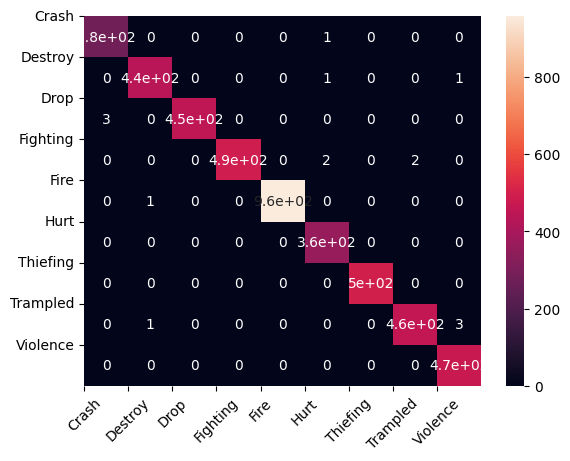

In [21]:
eval_model_f(model, X_test, y_test)

#3dcnn

###Note: for 3dcnn, do not run the "to categorical cell"

In [ ]:
dim = X_train[0].shape

In [ ]:
def create_model(dim):
  model = models.Sequential()
  # model.add(layers.BatchNormalization())
  model.add(layers.Conv3D(32, kernel_size=(3, 3, 1), activation='relu', kernel_initializer='he_uniform', data_format='channels_last', input_shape=dim))
  model.add(layers.MaxPooling3D((2, 2, 1)))
  # model.add(layers.BatchNormalization())
  #model.add(layers.Conv3D(32, kernel_size=(3, 3, 2), activation='relu', kernel_initializer='he_uniform'))
  #model.add(layers.MaxPooling3D((3, 3, 1)))
  # model.add(layers.BatchNormalization())
  model.add(layers.Conv3D(32, kernel_size=(3, 3, 1), activation='relu', kernel_initializer='he_uniform'))
  model.add(layers.MaxPooling3D((2, 2, 1)))
  # model.add(layers.BatchNormalization())
  model.add(layers.Flatten())
  # model.add(layers.Dropout(0.5))
  #model.add(layers.Dense(4096, activation='relu'))
  model.add(layers.Dense(1024, activation='relu'))
  # model.add(layers.BatchNormalization())
  #model.add(layers.Dropout(0.5))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(16, activation='relu'))
  # model.add(layers.BatchNormalization())
  model.add(layers.Dense(14, activation='softmax'))
  return model

In [ ]:
model = create_model(dim)
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 73, 73, 14, 32)    608       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 36, 36, 14, 32)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 34, 34, 14, 32)    9248      
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 17, 17, 14, 32)   0         
 3D)                                                             
                                                                 
 flatten (Flatten)           (None, 129472)            0         
                                                                 
 dense (Dense)               (None, 1024)              1

In [ ]:
checkpoint_filepath = '/content/gdrive/MyDrive/Checkpoints/run_lad_multi_of_cnn/checkpoint/'
model_checkpoint = model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                filepath=checkpoint_filepath,
                                save_weights_only=True,
                                monitor='val_loss',
                                mode='min',
                                save_best_only=True
                                )

In [ ]:
from keras.callbacks import ReduceLROnPlateau
checkpoint_filepath = '/content/gdrive/MyDrive/Checkpoints/run_lad_multi_of_cnn/checkpoint/'
model_checkpoint = model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
                                filepath=checkpoint_filepath,
                                save_weights_only=True,
                                monitor='val_loss',
                                mode='min',
                                save_best_only=True
                                )

earlystopping = tf.keras.callbacks.EarlyStopping(
                     monitor="val_loss",
                     min_delta=0.025,
                     patience=10,
                     verbose=0,
                     mode="min",
                     baseline=None,
                     restore_best_weights=False
                 )

values = np.linspace(0.00001,LEARNING_RATE,14)[::-1].astype(np.float32)
boundaries = np.linspace(5, 45,13)[:values.shape[0]-1].astype(np.int32)

scheduler = keras.optimizers.schedules.PiecewiseConstantDecay(
    list(boundaries), list(values))

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=0.000001)

callbacks = [model_checkpoint]

In [ ]:
dim

(75, 75, 14, 2)

In [ ]:
def run_experiment():
    mirrored_strategy = tf.distribute.MirroredStrategy(devices= ["/gpu:0"],cross_device_ops=tf.distribute.HierarchicalCopyAllReduce())
    with mirrored_strategy.scope():

        model2 = create_model(dim)
        optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
        model2.compile(
            optimizer=optimizer,
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=[
                keras.metrics.SparseCategoricalAccuracy(name="accuracy"),
                keras.metrics.SparseTopKCategoricalAccuracy(5, name="top-5-accuracy"),
            ],
        )
       # model2.load_weights(checkpoint_filepath)
        # Train the model.
        history = model2.fit(X_train, y_train, batch_size = 64, epochs=50, validation_data=(X_val, y_val))

    return model2, history


model2, history = run_experiment()

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


33/33 [==============================] - 23s 254ms/step - loss: 2.6308 - accuracy: 0.0985 - top-5-accuracy: 0.4614 - val_loss: 2.6175 - val_accuracy: 0.1007 - val_top-5-accuracy: 0.4479
Epoch 2/50
33/33 [==============================] - 7s 209ms/step - loss: 2.6200 - accuracy: 0.1009 - top-5-accuracy: 0.4367 - val_loss: 2.6135 - val_accuracy: 0.1007 - val_top-5-accuracy: 0.4514
Epoch 3/50
33/33 [==============================] - 6s 194ms/step - loss: 2.6165 - accuracy: 0.1043 - top-5-accuracy: 0.4478 - val_loss: 2.6127 - val_accuracy: 0.1007 - val_top-5-accuracy: 0.4653
Epoch 4/50
33/33 [==============================] - 7s 210ms/step - loss: 2.6162 - accuracy: 0.1009 - top-5-accuracy: 0.4634 - val_loss: 2.6130 - val_accuracy: 0.1007 - val_top-5-accuracy: 0.4514
Epoch 5/50
33/33 [==============================] - 7s 198ms/step - loss: 2.6151 - accuracy: 0.1009 - top-5-accuracy: 0.4483 - val_loss: 2.6113 - val_accuracy: 0.1007 - val_top-5-accuracy: 0.4653
Epoch 6/50
33/33 [============

In [ ]:
model2.evaluate(X_test, y_test)

19/19 [==============================] - 1s 40ms/step - loss: 2.6082 - accuracy: 0.1088 - top-5-accuracy: 0.4643


[2.608229637145996, 0.10884353518486023, 0.4642857015132904]

In [ ]:
y_pred = model2.predict(X_test)

19/19 [==============================] - 1s 34ms/step


In [ ]:
np.asarray(y_pred).shape

(588, 14)

In [ ]:
y_pred[0]

array([0.43696383, 0.58891726, 0.5129307 , 0.4929061 , 0.51663417,
       0.45525852, 0.589747  , 0.600718  , 0.44906256, 0.4481016 ,
       0.43623903, 0.44894215, 0.44785562, 0.48917446], dtype=float32)

In [ ]:
y_pred = np.argmax(y_pred,axis = -1)

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        32
           1       0.00      0.00      0.00        60
           2       0.00      0.00      0.00        44
           3       0.00      0.00      0.00        42
           4       0.00      0.00      0.00        45
           5       0.00      0.00      0.00        34
           6       0.00      0.00      0.00        60
           7       0.11      1.00      0.20        64
           8       0.00      0.00      0.00        33
           9       0.00      0.00      0.00        34
          10       0.00      0.00      0.00        32
          11       0.00      0.00      0.00        34
          12       0.00      0.00      0.00        34
          13       0.00      0.00      0.00        40

    accuracy                           0.11       588
   macro avg       0.01      0.07      0.01       588
weighted avg       0.01      0.11      0.02       588



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



In [ ]:
import plotly.figure_factory as ff
from sklearn.metrics import f1_score

def eval_model(model,x,y):
#     print(model.evaluate(x.reshape(x.shape+(1,)),y_encoded))
    y_pred = model.predict(x)
    y_pred = np.argmax(y_pred,axis = -1)
    #y_numbers = np.argmax(y,axis=-1)
   # f1_score(y_test, y_pred, average='micro')
    #print(f1_score)
    target_names = [
    'Crash',
    'Crowd',
    'Destroy',
    'Drop',
    'FallIntoWater',
    'Falling',
    'Fighting',
    'Fire',
    'Hurt',
    'Loitering',
    'Panic',
    'Thiefing',
    'Trampled',
    'Violence'
]
    labels = target_names
    tick_marks = np.arange(len(labels))

    print(classification_report(y_test, y_pred, target_names=target_names))
    
    z = tf.math.confusion_matrix(y_test,y_pred).numpy().astype(np.int64)
    z = np.around(z.astype('float') / z.sum(axis=1)[:, np.newaxis], decimals=3)

    x = target_names
    y = target_names

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]

    # set up figure 
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

    # add title
    fig.update_layout(title_text='<i><b>Confusion matrix</b></i>',
                    #xaxis = dict(title='x'),
                    #yaxis = dict(title='x')
                    )

    # add custom xaxis title
    fig.add_annotation(dict(font=dict(color="black",size=14),
                            x=0.5,
                            y=-0.15,
                            showarrow=False,
                            text="Predicted value",
                            xref="paper",
                            yref="paper"))

    # add custom yaxis title
    fig.add_annotation(dict(font=dict(color="black",size=14),
                            x=-0.35,
                            y=0.5,
                            showarrow=False,
                            text="Real value",
                            textangle=-90,
                            xref="paper",
                            yref="paper"))

    # adjust margins to make room for yaxis title
    fig.update_layout(margin=dict(t=50, l=200))

    # add colorbar
    fig['data'][0]['showscale'] = True
    fig.show()

In [ ]:
eval_model(model2,X_test,y_test)

19/19 [==============================] - 1s 32ms/step
               precision    recall  f1-score   support

        Crash       0.00      0.00      0.00        32
        Crowd       0.00      0.00      0.00        60
      Destroy       0.00      0.00      0.00        44
         Drop       0.00      0.00      0.00        42
FallIntoWater       0.00      0.00      0.00        45
      Falling       0.00      0.00      0.00        34
     Fighting       0.00      0.00      0.00        60
         Fire       0.11      1.00      0.20        64
         Hurt       0.00      0.00      0.00        33
    Loitering       0.00      0.00      0.00        34
        Panic       0.00      0.00      0.00        32
     Thiefing       0.00      0.00      0.00        34
     Trampled       0.00      0.00      0.00        34
     Violence       0.00      0.00      0.00        40

     accuracy                           0.11       588
    macro avg       0.01      0.07      0.01       588
 weighted

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
from sklearn.utils import shuffle
X2, y2 = shuffle(X_test, y_test, random_state=0)

In [ ]:
eval_model(model2,X2,y2)

19/19 [==============================] - 1s 33ms/step
               precision    recall  f1-score   support

        Crash       0.00      0.00      0.00        32
        Crowd       0.00      0.00      0.00        60
      Destroy       0.00      0.00      0.00        44
         Drop       0.00      0.00      0.00        42
FallIntoWater       0.00      0.00      0.00        45
      Falling       0.00      0.00      0.00        34
     Fighting       0.00      0.00      0.00        60
         Fire       0.11      1.00      0.20        64
         Hurt       0.00      0.00      0.00        33
    Loitering       0.00      0.00      0.00        34
        Panic       0.00      0.00      0.00        32
     Thiefing       0.00      0.00      0.00        34
     Trampled       0.00      0.00      0.00        34
     Violence       0.00      0.00      0.00        40

     accuracy                           0.11       588
    macro avg       0.01      0.07      0.01       588
 weighted

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning:

Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



#Decision Tree

#Evaluation

In [ ]:
import plotly.figure_factory as ff
from sklearn.metrics import f1_score

def eval_model(model,x,y):
#     print(model.evaluate(x.reshape(x.shape+(1,)),y_encoded))
    y_pred = model.predict(x)
    y_pred = np.argmax(y_pred,axis = -1)
    #y_numbers = np.argmax(y,axis=-1)
   # f1_score(y_test, y_pred, average='micro')
    #print(f1_score)
    target_names = [
    'Crash',
    'Crowd',
    'Destroy',
    'Drop',
    'FallIntoWater',
    'Falling',
    'Fighting',
    'Fire',
    'Hurt',
    'Loitering',
    'Panic',
    'Thiefing',
    'Trampled',
    'Violence'
]
    labels = target_names
    tick_marks = np.arange(len(labels))

    print(classification_report(y_test, y_pred, target_names=target_names))
    
    z = tf.math.confusion_matrix(y_test,y_pred).numpy().astype(np.int64)
    z = np.around(z.astype('float') / z.sum(axis=1)[:, np.newaxis], decimals=3)

    x = target_names
    y = target_names

    # change each element of z to type string for annotations
    z_text = [[str(y) for y in x] for x in z]

    # set up figure 
    fig = ff.create_annotated_heatmap(z, x=x, y=y, annotation_text=z_text, colorscale='Viridis')

    # add title
    fig.update_layout(title_text='<i><b>Confusion matrix</b></i>',
                    #xaxis = dict(title='x'),
                    #yaxis = dict(title='x')
                    )

    # add custom xaxis title
    fig.add_annotation(dict(font=dict(color="black",size=14),
                            x=0.5,
                            y=-0.15,
                            showarrow=False,
                            text="Predicted value",
                            xref="paper",
                            yref="paper"))

    # add custom yaxis title
    fig.add_annotation(dict(font=dict(color="black",size=14),
                            x=-0.35,
                            y=0.5,
                            showarrow=False,
                            text="Real value",
                            textangle=-90,
                            xref="paper",
                            yref="paper"))

    # adjust margins to make room for yaxis title
    fig.update_layout(margin=dict(t=50, l=200))

    # add colorbar
    fig['data'][0]['showscale'] = True
    fig.show()